# Finding topics in United Nations General Assembly debates

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.decomposition import NMF

Let's start this off by loading the data and taking a look at it. We have the text of each debate speech, the year and session it occurred in, and the country that gave it. There are over 7500 speeches in total, spanning the the period from 1970 to 2015. 

In [2]:
data = pd.read_csv('un-general-debates.csv')
data.head()

,session,year,country,text
0,44,1989,MDV,﻿It is indeed a pleasure for me and the member...
1,44,1989,FIN,"﻿\nMay I begin by congratulating you. Sir, on ..."
2,44,1989,NER,"﻿\nMr. President, it is a particular pleasure ..."
3,44,1989,URY,﻿\nDuring the debate at the fortieth session o...
4,44,1989,ZWE,﻿I should like at the outset to express my del...


There are a few more speeches given in more recent years.

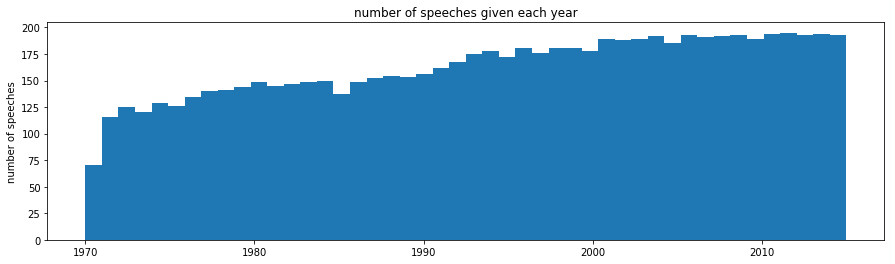

In [3]:
plt.figure(figsize=(15,4))
plt.hist(data.year, bins=len(data.year.unique()))
plt.ylabel('number of speeches')
plt.title('number of speeches given each year')
plt.show()

A first cut at topics, using bag-of-words and NMF. I'm excluding the basic English "stop words" from the NLTK library. These are words like "the", "of", etc. that don't add meaning to the speech.

In [4]:
stops = set(nltk.corpus.stopwords.words('english'))
bow = CountVectorizer(stop_words=stops)
bag = bow.fit_transform(data.text)

In [5]:
nmf = NMF(n_components=5)
W = nmf.fit_transform(bag)
H = nmf.components_

Let's look at some of the top words in each topic:

In [6]:
words = bow.get_feature_names()
words = np.array(words)
words[np.argsort(H, axis=1)][:,-20:]

array([['assembly', 'also', 'operation', 'session', 'general',
        'developed', 'community', 'nations', 'problems', 'co', 'south',
        'africa', 'new', 'must', 'developing', 'development', 'economic',
        'world', 'international', 'countries'],
       ['many', 'assembly', 'council', 'organization', 'one', 'also',
        'peace', 'security', 'global', 'rights', 'general', 'us', 'new',
        'states', 'development', 'human', 'must', 'world', 'united',
        'nations'],
       ['operation', 'disarmament', 'union', 'war', 'republic',
        'military', 'co', 'relations', 'weapons', 'peoples', 'security',
        'soviet', 'world', 'countries', 'peace', 'nations', 'nuclear',
        'international', 'united', 'states'],
       ['organization', 'cooperation', 'government', 'support',
        'process', 'human', 'region', 'economic', 'political', 'rights',
        'country', 'also', 'general', 'council', 'efforts',
        'development', 'community', 'peace', 'security', 'in

Hmmm. Some of these words aren't too meaningful in the context of the UN general assembly. Words like "nation" and "assembly" are going to be so common in these speeches as to be more or less meaningless in tying to distinguish between speech topics. So let's add to our list of stop words and run the NMF again.

In [7]:
stops2 = stops.union(set(['general', 'assembly',
        'government', 'country', 'people',
        'international', 'world', 'countries', 'also',
        'united', 'must', 'state', 'session',
        'nations', 'union'
        'policy', 'relations', 'nations', 'peoples',
        'region', 'political', 'country',
        'council']))

In [8]:
bow = CountVectorizer(stop_words=stops2)
bag = bow.fit_transform(data.text)

In [9]:
nmf = NMF(n_components=5)
W = nmf.fit_transform(bag)
H = nmf.components_

Looking at the top words in each topic again (note that the last word in each list is the top word):

In [10]:
words = bow.get_feature_names()
words = np.array(words)
words[np.argsort(H, axis=1)][:,-40:]

array([['force', 'east', 'efforts', 'foreign', 'problems', 'powers',
        'race', 'one', 'interests', 'important', 'situation', 'struggle',
        'independence', 'democratic', 'socialist', 'use', 'treaty',
        'forces', 'peaceful', 'non', 'economic', 'conference', 'europe',
        'new', 'operation', 'would', 'arms', 'policy', 'co',
        'disarmament', 'war', 'military', 'union', 'security', 'weapons',
        'peace', 'republic', 'soviet', 'nuclear', 'states'],
       ['action', 'well', 'financial', 'national', 'conflict', 'trade',
        'issues', 'continue', 'agenda', 'secretary', 'change', 'poverty',
        'climate', 'member', 'role', 'sustainable', 'reform',
        'important', 'work', 'regional', 'challenges', 'need', 'year',
        'organization', 'social', 'process', 'rights', 'developing',
        'support', 'states', 'cooperation', 'new', 'efforts', 'human',
        'community', 'economic', 'global', 'peace', 'security',
        'development'],
       ['self

Looks like we're getting some separation in the topics now, but some of them are still a bit vague. We might call them:  
0) World peace and Soviet/Western relations  
1) This one still seems a little vague. Maybe economic development?  
2) South Africa   
3) The Middle East  
4) Again, somewhat vague, seems to relate to world peace and human rights.

Let's try TF-IDF instead of Count Vectorizer (bag of words). Count Vectorizer makes groupings based on simple counts of words - so words that appear most frequently are given the most weight. In contrast, TF-IDF (term frequency inverse document frequency) divides the frequency of each word in each document by how many documents it appears in overall. So a word that appears frequently in one document but not in many other documents is given greater weight than a word that appears frequently in many documents.

In [30]:
tfidf = TfidfVectorizer(stop_words=stops2, ngram_range=(1,3))
tf = tfidf.fit_transform(data.text)

In [31]:
nmf = NMF(n_components=5)
W = nmf.fit_transform(tf)
H = nmf.components_

In [33]:
words = tfidf.get_feature_names()
words = np.array(words)
words[np.argsort(H, axis=1)][:,-40:]

array([['southern', 'third', 'time', 'rights', 'developed', 'human',
        'great', 'mankind', 'hope', 'regime', 'powers', 'solution',
        'efforts', 'order', 'would', 'one', 'conference', 'apartheid',
        'problem', 'us', 'situation', 'new', 'independence', 'states',
        'community', 'delegation', 'problems', 'namibia', 'development',
        'developing', 'organization', 'african', 'operation',
        'south africa', 'co operation', 'peace', 'co', 'south',
        'economic', 'africa'],
       ['today', 'years', 'african', 'member', 'like', 'regional',
        'democratic', 'year', 'important', 'millennium', 'work',
        'sustainable', 'one', 'need', 'conflict', 'poverty', 'european',
        'democracy', 'social', 'would', 'challenges', 'support',
        'process', 'reform', 'organization', 'efforts', 'states', 'us',
        'terrorism', 'economic', 'new', 'community', 'global',
        'cooperation', 'human rights', 'rights', 'human', 'peace',
        'security',

Topics again:  
0) South Africa  
1) Human rights, economic development, and terrorism (this one is still vague)  
2) Climate change and island nations  
3) The Cold War  
4) The Middle East  

NMF gives us an "amount" that each topic contributes to each speech. Let's go ahead and assign each speech it's highest valued topic.

In [34]:
top_topic = np.argmax(W, axis=1)
data["top_topic"] = top_topic
data.loc[data['top_topic'] == 0, 'topic_name'] = 'South Africa'
data.loc[data['top_topic'] == 1, 'topic_name'] = 'Human rights, economic development, and terrorism'
data.loc[data['top_topic'] == 2, 'topic_name'] = 'Climate change'
data.loc[data['top_topic'] == 3, 'topic_name'] = 'Cold War'
data.loc[data['top_topic'] == 4, 'topic_name'] = 'The Middle East'

Plotting those how many speeches fit into each topic each year gives us the following. This is pretty interesting, and not far off what we might expect, if you know modern history! Climate change has really only come up as a major topic in the past few decades. Talk of South Africa dropped to near zero as soon as aparteid ended and Namibia was given independence in 1990. 

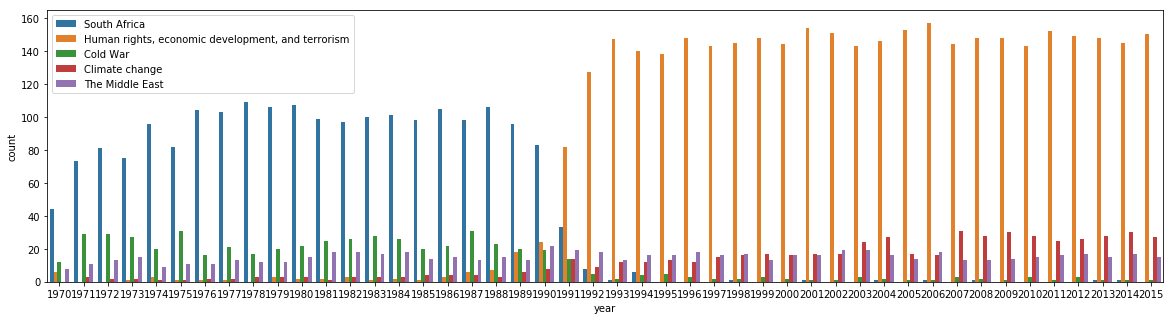

In [35]:
plt.figure(figsize=(20,5))
sns.countplot(x='year', hue='topic_name', data=data)
plt.legend(loc=2)

The most common topic is still this somewhat vague catchall of "Human rights, economic development, and terrorism". So what if we add a few more categories, will this catchall start to break up?

In [22]:
tfidf = TfidfVectorizer(stop_words=stops2, ngram_range=(1,2))
tf = tfidf.fit_transform(data.text)

nmf = NMF(n_components=7)
W = nmf.fit_transform(tf)
H = nmf.components_

words = tfidf.get_feature_names()
words = np.array(words)
words[np.argsort(H, axis=1)][:,-40:]

array([['peaceful', 'community', 'towards', 'human rights', 'progress',
        'year', 'european', 'settlement', 'south', 'non', 'solution',
        'organization', 'important', 'treaty', 'soviet', 'problem',
        'would', 'human', 'cyprus', 'detente', 'development', 'arms',
        'negotiations', 'rights', 'developing', 'efforts', 'weapons',
        'europe', 'new', 'security', 'problems', 'conference',
        'economic', 'states', 'peace', 'disarmament', 'nuclear',
        'operation', 'co operation', 'co'],
       ['summit', 'work', 'sustainable development', 'would',
        'democratic', 'stability', 'peacekeeping', 'would like', 'need',
        'important', 'member', 'role', 'republic', 'regional', 'poverty',
        'union', 'european union', 'conflict', 'economic', 'states',
        'millennium', 'organization', 'european', 'support',
        'sustainable', 'process', 'new', 'challenges', 'efforts',
        'reform', 'terrorism', 'community', 'global', 'rights',
        '

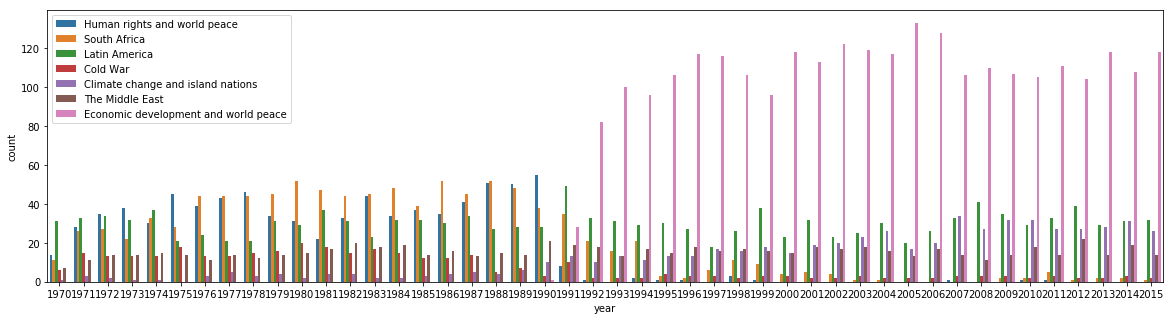

In [29]:
top_topic = np.argmax(W, axis=1)
data["top_topic"] = top_topic

data.loc[data['top_topic'] == 0, 'topic_name'] = 'Human rights and world peace'
data.loc[data['top_topic'] == 1, 'topic_name'] = 'Economic development and world peace'
data.loc[data['top_topic'] == 2, 'topic_name'] = 'South Africa'
data.loc[data['top_topic'] == 3, 'topic_name'] = 'The Middle East'
data.loc[data['top_topic'] == 4, 'topic_name'] = 'Climate change and island nations'
data.loc[data['top_topic'] == 5, 'topic_name'] = 'Latin America'
data.loc[data['top_topic'] == 6, 'topic_name'] = 'Cold War'

plt.figure(figsize=(20,5))
sns.countplot(x='year', hue='topic_name', data=data)
plt.legend(loc=2)

We still see that Climate change is a more recent topic, and talk of South Africa and the Cold War die off in the early 1990s. Latin America (a new topic!) and the Middle East are topics of discussion throughout this period.

As we make more topics, the common "South Africa" topic starts to break into other topics. With 5 topics, South Africa had roughly 90 speeches per year (prior to 1991). With 7 topics, it's down to roughly 50 speeches per year, and those other 40 speeches have been reassigned to new topics of "Latin America" and "Human rights and world peace".

The catchall, in contrast, hasn't broken up much and is still by far the most common topic since 1992.

So what can we say about all this? First, it appears that in the early 1990s, there was a major shift in the speeches at the UN. The speeches appear to have become much more similar to each other and much more vague.